In [1]:
import torch
import torchvision
import numpy as np
from dataset import NuScenes, KITTI
from intern_dataset import InternData
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from distnet import DistResNeXt50
from albumentations import (OneOf,
                            HueSaturationValue,
                            RandomBrightnessContrast,
                            Blur,
                            GaussNoise,
                            CLAHE,
                            RGBShift)


In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [14]:
# define an albumentations augmentation routine
alb_aug_list = [HueSaturationValue(hue_shift_limit=20,
                                   sat_shift_limit=30,
                                   val_shift_limit=20,
                                   p=1),
                RandomBrightnessContrast(brightness_limit=0.2,
                                         contrast_limit=0.2,
                                         brightness_by_max=True,
                                         p=1),
                Blur(blur_limit=7,
                     p=1),
                GaussNoise(var_limit=(10.0, 50.0),
                           mean=0,
                           p=1),
                CLAHE(clip_limit=4.0,
                      tile_grid_size=(8, 8),
                      p=1),
                RGBShift(p=1)
                ]
train_aug = OneOf(alb_aug_list, p=0.7)

# create a transforms routine
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
    mean=[
        0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])

size = 1024


# create training dataset and loader
# nuscenes_train = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/intern_data/nuscenes-full/',
#                           meta_path='/irad_mounts/lambda-quad-5-data/beholder/intern_data/nuscenes-full/nuscenes-v1.0.csv',
#                           split='train',
#                           augs=train_aug,
#                           transforms=transforms,
#                           size=size,
#                           map_to_kitti=True,
#                           norm=False,
#                           mlp=True)

# nuscenes_test = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/intern_data/nuscenes-full/',
#                          meta_path='/irad_mounts/lambda-quad-5-data/beholder/intern_data/nuscenes-full/nuscenes-v1.0.csv',
#                          split='test',
#                          transforms=transforms,
#                          size=size,
#                          map_to_kitti=True,
#                          norm=False,
#                          mlp=True)

nuscenes_train = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/',
                          meta_path='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/nuscenes-v1.0-mini.csv',
                          split='train',
                          augs=train_aug,
                          transforms=transforms,
                          size=size,
                          map_to_kitti=True,
                          norm=False,
                          mlp=True)

nuscenes_test = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/',
                         meta_path='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/nuscenes-v1.0-mini.csv',
                         split='test',
                         transforms=transforms,
                         size=size,
                         map_to_kitti=True,
                         norm=False,
                         mlp=True)

intern_train = InternData(img_dir="/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data",
                          meta_path="/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotations.csv",
                          transforms=transforms,
                          augs=train_aug,
                          split='train',
                          size=size,
                          map_to_kitti=True,
                          norm=False)

intern_test = InternData(img_dir="/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data",
                         meta_path="/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotations.csv",
                         transforms=transforms,
                         split='test',
                         size=size,
                         map_to_kitti=True,
                         norm=False)

kitti_train = KITTI(img_dir='/irad_mounts/lambda-quad-5-data/beholder/KITTI-distance-estimation/original_data/train_images/',
                   meta_path='/irad_mounts/lambda-quad-5-data/beholder/KITTI-distance-estimation/annotations.csv',
                   split = 'train',
                   augs = train_aug,
                   transforms=transforms,
                   size=size)

kitti_test = KITTI(img_dir='/irad_mounts/lambda-quad-5-data/beholder/KITTI-distance-estimation/original_data/train_images/',
                   meta_path='/irad_mounts/lambda-quad-5-data/beholder/KITTI-distance-estimation/annotations.csv',
                   split = 'test',
                   transforms=transforms,
                   size=size)

In [19]:
print(len(nuscenes_train))
print(len(nuscenes_test))

1623
426


In [17]:
# print(nuscenes_train[0][3])

trainloader = torch.utils.data.DataLoader(nuscenes_train, batch_size=4, drop_last=True, shuffle=True, collate_fn=nuscenes_train.collate_fn)
print(len(trainloader))
# for batch in trainloader:
#     print(torch.cat([torch.cat([bbox, class_encoding], dim=1) for bbox, class_encoding in zip(batch[1], batch[3])]))
#     break

405


In [5]:
temp = [nuscenes_train.metadata['distance'].max(),
        nuscenes_train.metadata['distance'].min(),
        nuscenes_test.metadata['distance'].max(),
        nuscenes_test.metadata['distance'].min(),
       ]
print(temp)
print(max(temp), min(temp))
temp.append(intern_train.metadata['distance'].max())
temp.append(intern_train.metadata['distance'].min())
temp.append(intern_test.metadata['distance'].max())
temp.append(intern_test.metadata['distance'].min())

print(temp)
print(max(temp), min(temp))

[311.4842790022132, 0.914273901974966, 273.2608282268632, 1.1142140904567028]
311.4842790022132 0.914273901974966
[311.4842790022132, 0.914273901974966, 273.2608282268632, 1.1142140904567028, 177.0, 5.0, 132.0, 2.18]
311.4842790022132 0.914273901974966


In [6]:
train_data = torch.utils.data.ConcatDataset([nuscenes_train, intern_train, kitti_train])
test_data = torch.utils.data.ConcatDataset([nuscenes_test, intern_test, kitti_test])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, drop_last=True,shuffle=True, collate_fn=kitti_train.collate_fn)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, drop_last=True, shuffle=False, collate_fn=kitti_train.collate_fn)

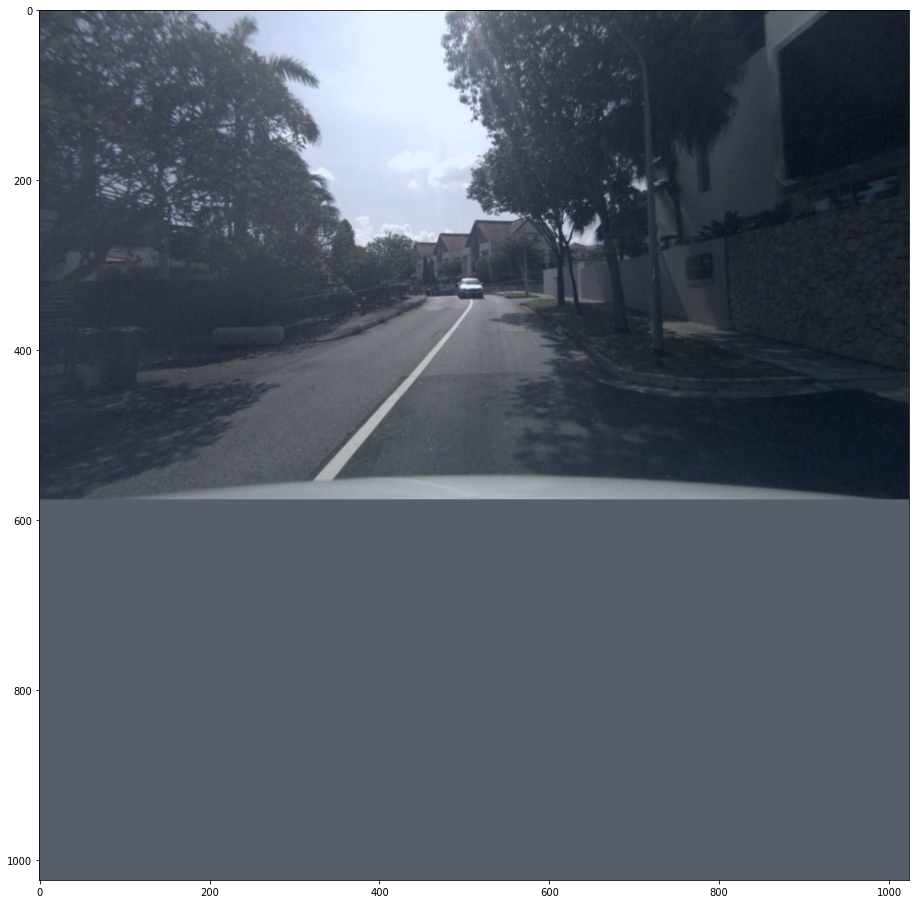

In [7]:
# plot some example test data
idx = 12345
image,boxes,distances,classes = test_data.__getitem__(idx)
image,boxes,classes = image.numpy(),boxes.numpy(),classes.numpy()
fig,ax = plt.subplots(figsize=(20,16))

# fix image range
image_shape = np.shape(image)
image = image.flatten()
im_max = image.max()
im_min = image.min()
image = (image - im_min) / (im_max - im_min)
image = np.reshape(image, image_shape)
    
ax.imshow(np.transpose(image, (1,2,0)))
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0],boxes[i][3]),
                             boxes[i][2]-boxes[i][0],
                             boxes[i][1]-boxes[i][3],
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none',
                             label='object')
    ax.add_patch(rect)
plt.show()

In [8]:
%%capture
# load in our model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DistResNeXt50(n_classes=8, image_size=size)
model.to(device)

KeyboardInterrupt: 

In [9]:
# define our loss function
class_criterion = torch.nn.CrossEntropyLoss()
dist_criterion = torch.nn.MSELoss()

In [10]:
# define some hyperparameters
n_epochs = 1
lr = 1e-6
weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

NameError: name 'model' is not defined

In [ ]:
# define our training routine
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    # train loop
    running_train_loss = 0.0

    model.train()
    print('Training...')
    for i,data in enumerate(trainloader, 0):

        # grab the batch and move the batch to the gpu
        inputs,boxes,distances,classes = data[0],data[1],data[2],data[3]
        inputs = inputs.to(device)
        boxes = [b.to(device) for b in boxes]
        distances = torch.cat([d.to(device) for d in distances])
        classes = torch.cat([c.to(device) for c in classes])

        # zero param gradients
        optimizer.zero_grad()
        
        # forward, backward, optimize
        class_preds,distance_preds = model(inputs, boxes)
        loss = class_criterion(class_preds.squeeze(), classes) + 10.0*dist_criterion(distance_preds.squeeze(), distances)
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if (i%100)==0:
            print('batch [{0:}] - loss: {1:.3f}'.format(i,running_train_loss/(i+1)))

    # end of epoch train stats
    train_loss = running_train_loss/(i+1)
    train_losses.append(train_loss)

    # validation loop
    running_val_loss = 0.0

    model.eval()
    print('Performing eval...')
    with torch.no_grad():
        for i,data in enumerate(testloader, 0):
            
            # grab the batch and move the batch to the gpu
            inputs,boxes,distances,classes = data[0],data[1],data[2],data[3]
            inputs = inputs.to(device)
            boxes = [b.to(device) for b in boxes]
            distances = torch.cat([d.to(device) for d in distances])
            classes = torch.cat([c.to(device) for c in classes])

            # forward, backward, optimize
            class_preds,distance_preds = model(inputs, boxes)
            loss = class_criterion(class_preds.squeeze(), classes) + 10.0*dist_criterion(distance_preds.squeeze(), distances)
            running_val_loss += loss.item()

    # calculate final val loss and step scheduler
    val_loss = running_val_loss/(i+1)
    val_losses.append(val_loss)

    # save the model every epoch
#     torch.save(model.state_dict(), '/irad_mounts/lambda-quad-5-data/beholder/distnet_weights_fine/distnet_resnext_epoch_{}.pth'.format(epoch))
    
    # print stats
    print('End of epoch stats...')
    print('--------------------------------------------------------------------------------------')
    print('epoch [{0:}] - train_loss: {1:.3f} - val_loss: {2:.3f}'.format(epoch, train_loss, val_loss))
    print('--------------------------------------------------------------------------------------')

In [ ]:
# plot losses
fig,ax = plt.subplots(1, sharex=True, figsize=(6,6))
ax.plot(train_losses)
ax.plot(val_losses)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'])
# plt.savefig('losses.png')
plt.show()